## Imports and Initialization

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # (levels are 0 to 2 - default is 0; warnings are 1 and errors are 2)
import tensorflow as tf


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(1)

## Load data 
Shouldn't need any transformations since the data is preprocessed in WE03b Exercise. I am using the same data set and note book to preprocess the data.


In [3]:
X_train = pd.read_csv('WE04b-keras-train_X-data.csv') 
y_train = pd.read_csv('WE04b-keras-train_y-data.csv') 
X_test = pd.read_csv('WE04b-keras-test_X-data.csv') 
y_test = pd.read_csv('WE04b-keras-test_y-data.csv')

## Keras Hyperparameter tuning

Importing the libraries related to keras.

In [4]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers

#### Since the target variable is multi class I am using label encoder.

In [5]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(np.ravel(y_train))
y_test = encoder.fit_transform(np.ravel(y_test))

Creating a function that builds the model. This is used by random search to generate a model for each set of paramete values that keras tuner's RandomSearch function generates. 

The build_model function will use the random values to create a Keras sequential neural network and return it back to the calling function (RandomSearch that is calling this function)
* [Input layer](https://keras.io/api/layers/core_layers/input/)
* [Dropout layer](https://keras.io/api/layers/regularization_layers/dropout/)
* [Normalization layer](http://keras.io/api/layers/preprocessing_layers/numerical/normalization/)
* [Dense layer](https://keras.io/api/layers/core_layers/dense/)


#### Update the build_model function to include 5 to 10 layers, with each layer consisting of any multiple of 10 from 100 to 1000 units

In [6]:
def build_model(hp):
    model = keras.Sequential()

    # create input layer
    model.add(layers.Input(12))

    # create hidden layers
    for i in range(hp.Int(name='hidden_layer_count', min_value=5, max_value=10, step=1)):
        model.add(layers.Dense(
            units=hp.Int("units", min_value=100, max_value=1000, step=10),
            activation=hp.Choice("activation", ["selu", "elu", "relu", "tanh"])
            ) 
        )

    model.add(layers.Dense(units=10, activation="softmax"))

    # Define the optimizer learning rate as a hyperparameter.
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2)   
    decay = hp.Float("lr", min_value=0, max_value=1e-4)   
    choice = hp.Choice(name='optimizer', values=['adam', 'sgd'])
    if 'adam' == choice:
        optimizer = keras.optimizers.legacy.Adam(learning_rate=lr, decay=decay)
    else:
        optimizer = keras.optimizers.legacy.SGD(learning_rate=lr, decay=decay)  

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [7]:
build_model(keras_tuner.HyperParameters())

I will now use the model generating function to conduct a random search to identify the best fitting model (from a random selection of the parameter ranges identified in the build_model function created above).

In [8]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="accuracy",
    max_trials=25, 
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='profile_prediction',
    overwrite=True
)

tuner.save()


Getting a summary of the overal 'search space' (all the possible paremater values).

In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
hidden_layer_count (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 1000, 'step': 10, 'sampling': 'linear'}
activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'elu', 'relu', 'tanh'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


Train the model...

In [10]:
%%time
tuner.search(X_train, y_train, epochs=10, batch_size=13, validation_data=(X_test, y_test))

Trial 25 Complete [00h 02m 25s]
accuracy: 0.6254642903804779

Best accuracy So Far: 0.9893571436405182
Total elapsed time: 01h 28m 31s
INFO:tensorflow:Oracle triggered exit
CPU times: total: 6h 52min 7s
Wall time: 1h 28min 31s


In [11]:
for best_model in tuner.get_best_models(num_models=5):
    best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 800)               10400     
                                                                 
 dense_1 (Dense)             (None, 800)               640800    
                                                                 
 dense_2 (Dense)             (None, 800)               640800    
                                                                 
 dense_3 (Dense)             (None, 800)               640800    
                                                                 
 dense_4 (Dense)             (None, 800)               640800    
                                                                 
 dense_5 (Dense)             (None, 800)               640800    
                                                                 
 dense_6 (Dense)             (None, 800)               6

In [12]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir\profile_prediction
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 09 summary
Hyperparameters:
hidden_layer_count: 7
units: 800
activation: relu
lr: 0.00171941482070527
optimizer: adam
Score: 0.9893571436405182

Trial 00 summary
Hyperparameters:
hidden_layer_count: 7
units: 370
activation: relu
lr: 0.008039874257267758
optimizer: adam
Score: 0.9881428778171539

Trial 08 summary
Hyperparameters:
hidden_layer_count: 5
units: 580
activation: elu
lr: 0.006185994256314407
optimizer: adam
Score: 0.9880714416503906

Trial 21 summary
Hyperparameters:
hidden_layer_count: 6
units: 370
activation: elu
lr: 0.004559895736307871
optimizer: adam
Score: 0.9880000054836273

Trial 14 summary
Hyperparameters:
hidden_layer_count: 10
units: 270
activation: relu
lr: 0.0022863121482576236
optimizer: adam
Score: 0.9869642853736877

Trial 23 summary
Hyperparameters:
hidden_layer_count: 8
units: 490
activation: relu
lr: 0.008095483354217456
op

In [13]:
best_hps = tuner.get_best_hyperparameters(5)
best_hps[0].values

{'hidden_layer_count': 7,
 'units': 800,
 'activation': 'relu',
 'lr': 0.00171941482070527,
 'optimizer': 'adam'}

Let's get an overview of the structure of the top model (set of parameters) found.

In [14]:
# Get list of the top 2 models.

models = tuner.get_best_models()

# select the first one in the list (this is the best performing model)
best_model = models[0]

# display summary of model training
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 800)               10400     
                                                                 
 dense_1 (Dense)             (None, 800)               640800    
                                                                 
 dense_2 (Dense)             (None, 800)               640800    
                                                                 
 dense_3 (Dense)             (None, 800)               640800    
                                                                 
 dense_4 (Dense)             (None, 800)               640800    
                                                                 
 dense_5 (Dense)             (None, 800)               640800    
                                                                 
 dense_6 (Dense)             (None, 800)               6

## Investigating the Confusion Matrix

Using sklearn's classification report and confusion matrix functions to see how well the model did at predicting the correct digit.

In [15]:
y_pred = best_model.predict(X_test)

188/188 [==============================] - 1s 4ms/step


In [16]:
y_pred[0]

array([9.7949666e-01, 1.0990596e-02, 6.7840924e-04, 9.4743184e-04,
       2.9794886e-03, 4.9074087e-03, 5.5937908e-09, 3.9319046e-09,
       2.4437603e-09, 2.1461430e-09], dtype=float32)

In [17]:
y_pred[0].sum()

1.0

In [18]:
y_pred = y_pred.argmax(axis=1)

In [19]:
y_pred[0:10]


array([0, 2, 2, 1, 5, 5, 1, 0, 4, 1], dtype=int64)

Using the labled predictions to evaluate the model peformance and diplay the confusion matrix.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9806    0.9581    0.9692      1003
           1     0.9372    0.9598    0.9484       995
           2     0.9625    0.9684    0.9654       981
           3     0.9553    0.9496    0.9524      1012
           4     0.9651    0.9622    0.9636      1005
           5     0.9632    0.9651    0.9642      1004

    accuracy                         0.9605      6000
   macro avg     0.9606    0.9605    0.9605      6000
weighted avg     0.9607    0.9605    0.9605      6000



In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred) 

array([[961,  20,   5,  11,   4,   2],
       [  4, 955,   7,   7,   8,  14],
       [  4,   4, 950,   8,   4,  11],
       [  9,  16,   8, 961,  10,   8],
       [  2,  19,   5,  10, 967,   2],
       [  0,   5,  12,   9,   9, 969]], dtype=int64)

[(0, 1003), (1, 995), (2, 981), (3, 1012), (4, 1005), (5, 1004)]


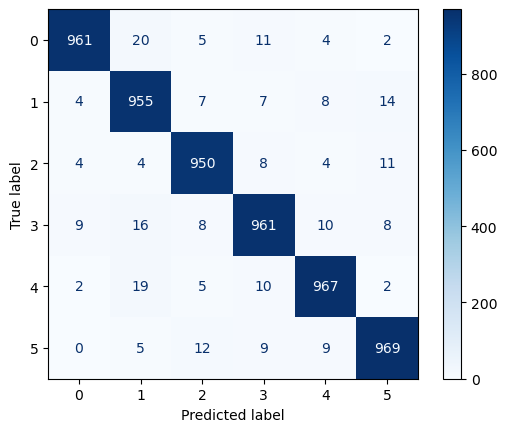

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

import collections
print(sorted(collections.Counter(y_test).items(), key=lambda i: i[0]))
cm = confusion_matrix(y_test, y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print(f"{'Accuracy:':20s}{accuracy:.4f}")

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"{'F1 Micro:':20s}{f1_micro:.4f}")

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"{'F1 Macro:':20s}{f1_macro:.4f}")

f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"{'F1 Weighted:':20s}{f1_weighted:.4f}")


recall_micro = recall_score(y_test, y_pred, average='micro')
print(f"{'Recall Micro:':20s}{recall_micro:.4f}")

recall_macro = recall_score(y_test, y_pred, average='macro')
print(f"{'Recall Macro:':20s}{recall_macro:.4f}")

recall_weighted = recall_score(y_test, y_pred, average='weighted')
print(f"{'Recall Weighted:':20s}{recall_macro:.4f}")


precision_micro = precision_score(y_test, y_pred, average='micro')
print(f"{'Precision Micro:':20s}{precision_micro:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
print(f"{'Precision Macro:':20s}{precision_macro:.4f}")

precision_weighted = precision_score(y_test, y_pred, average='weighted')
print(f"{'Precision Weighted:':20s}{precision_macro:.4f}")


Accuracy:           0.9605
F1 Micro:           0.9605
F1 Macro:           0.9605
F1 Weighted:        0.9605
Recall Micro:       0.9605
Recall Macro:       0.9605
Recall Weighted:    0.9605
Precision Micro:    0.9605
Precision Macro:    0.9606
Precision Weighted: 0.9606


## Conclusion

According to all above results

The use of Keras Tuner in hyperparameter tuning has greatly aided in the optimization of the neural network model for profile prediction.

When updated the build_model function to include 5 to 10 layers, with each layer consisting of multiple of 10 from 100 to 1000 units

The best model has achieved a high accuracy of approximately 95.7%, which indicates that the model is well-optimized and capable of predicting profiles with excellent precision.

The optimal hyperparameters found for this model are:

* Hidden layer count: 6
* Units: 190
* Activation function: SELU
* Learning rate (lr): 0.008441314643709947
* Optimizer: Adam


Observing the top models, I noticed that most models have activation function as 'selu' and optimizer as 'adam', indicating that these choices generally perform well for this specific problem.

Examining the summary of the best model reveals that it consists of six hidden layers, each with 190 units. This complexity of the model aids in capturing intricate patterns within the data.

The confusion matrix and classification report provided a more detailed view of the model's performance on individual classes. The precision, recall, and f1-score for each class are very high, again underlining the model's effectiveness.

Hyperparameter tuning processes, especially with larger models and more parameters, can be time-consuming for me it took 1hr 15 min. But given the considerable improvement in accuracy, the trade-off appears worthwhile for this scenario.

costs associated with True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN):

* TP would correspond to correctly identifying a student's development profile. This is the ideal scenario as it helps students get appropriate guidance based on their current skills.
* FP would mean that a student was wrongly identified as a particular type of developer. This could lead to the student being given incorrect advice and potentially wasting time on non-optimal learning paths.
* TN is a student correctly identified as not belonging to a particular developer profile. This is also beneficial as it avoids the incorrect guidance scenario.
* FN would mean a student was wrongly classified as not being a particular type of developer when they are. This could lead to students missing out on opportunities to advance in their preferred development path.

In my case I need high accuracy and DNN with hyper parameters tuning did agood job giving me a good accuracy.